# BORAN

In [1]:
# All imports
import pandas as pd
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.cm as cm
import nltk
import os
from nltk.corpus import PlaintextCorpusReader, stopwords
import string
import numpy as np
from nltk.tokenize import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Let's try reading the CSV file using a semicolon as the delimiter
got_df = pd.read_csv("../Game_of_Thrones_Script.csv", delimiter=';')

# Display the first few rows of the dataframe to understand its structure
got_df.head()

,Release Date,Season,Episode,Episode Title,Name,Sentence
0,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...
1,2011-04-17,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...
2,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?
3,2011-04-17,Season 1,Episode 1,Winter is Coming,will,Close as any man would.
4,2011-04-17,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.


In [10]:
# Getting the unique names
unique_characters = got_df['Name'].unique()

# Providing the complete list of unique characters
unique_characters_list = list(unique_characters)

# Displaying the total number of unique characters
total_characters = len(unique_characters_list)

In [13]:
# Function to process a batch of lines
def process_batch(batch):
    character_counts = Counter(batch['Name'])
    interactions = [(char1, char2) for char1 in character_counts for char2 in character_counts if char1 != char2 and character_counts[char1] > 1 and character_counts[char2] > 1]
    return interactions

# Function to process each episode
def process_episode(episode_df):
    interactions = []
    for start in range(0, len(episode_df), 10):
        batch = episode_df.iloc[start:start + 10]
        batch_interactions = process_batch(batch)
        interactions.extend(batch_interactions)
    return interactions

# Analyze each season and episode
seasons = got_df['Season'].unique()
season_graphs = {}

for season in seasons:
    season_df = got_df[got_df['Season'] == season]
    episodes = season_df['Episode'].unique()
    season_interactions = Counter()

    for episode in episodes:
        episode_df = season_df[season_df['Episode'] == episode]
        interactions = process_episode(episode_df)
        season_interactions.update(interactions)

    # Create a graph for the season
    G = nx.Graph()
    for (char1, char2), count in season_interactions.items():
        G.add_edge(char1, char2, weight=count)
    
    season_graphs[season] = G

In [14]:
def process_episode_with_rolling_window_unique(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        # Update interactions count for each unique pair of interacting characters
        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Processing each episode in each season using the rolling window approach
season_interactions_unique = {}
for season in got_df['Season'].unique():
    season_df = got_df[got_df['Season'] == season]
    season_interactions_unique[season] = Counter()

    for episode in season_df['Episode'].unique():
        episode_df = season_df[season_df['Episode'] == episode]
        episode_interactions = process_episode_with_rolling_window_unique(episode_df)
        season_interactions_unique[season].update(episode_interactions)

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1)
top_10_interactions_season_1_unique = season_interactions_unique['Season 1'].most_common(10)
print(top_10_interactions_season_1_unique)

[(frozenset({'eddard stark', 'robert baratheon'}), 211), (frozenset({'jorah mormont', 'daenerys targaryen'}), 169), (frozenset({'eddard stark', 'petyr baelish'}), 165), (frozenset({'eddard stark', 'cersei lannister'}), 144), (frozenset({'eddard stark', 'arya stark'}), 141), (frozenset({'jon snow', 'sam'}), 138), (frozenset({'shae', 'tyrion lannister'}), 99), (frozenset({'robb stark', 'catelyn stark'}), 97), (frozenset({'robert baratheon', 'cersei lannister'}), 94), (frozenset({'bronn', 'tyrion lannister'}), 88)]


In [15]:
## Filtering out too-general characters from the interactions
# Re-defining the list of non-specific character names to remove
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page", "kings soldier", "frey man", "frey men", "announcer",
    "guard captain", "captain", "handmaiden", "steward"
]

# Re-defining the function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        # Ensure both characters in the pair are not in the non-specific list
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Apply the filter to each season's interactions
filtered_season_interactions = {}
for season in season_interactions_unique:
    filtered_season_interactions[season] = filter_interactions(season_interactions_unique[season])

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1) after filtering
filtered_top_10_season_1 = filtered_season_interactions['Season 1'].most_common(10)
filtered_top_10_season_1

[(frozenset({'eddard stark', 'robert baratheon'}), 211),
 (frozenset({'daenerys targaryen', 'jorah mormont'}), 169),
 (frozenset({'eddard stark', 'petyr baelish'}), 165),
 (frozenset({'cersei lannister', 'eddard stark'}), 144),
 (frozenset({'arya stark', 'eddard stark'}), 141),
 (frozenset({'jon snow', 'sam'}), 138),
 (frozenset({'shae', 'tyrion lannister'}), 99),
 (frozenset({'catelyn stark', 'robb stark'}), 97),
 (frozenset({'cersei lannister', 'robert baratheon'}), 94),
 (frozenset({'bronn', 'tyrion lannister'}), 88)]

In [16]:
# Saving all interactions per season into an xlsx file
def create_interaction_dataframe_filtered(interactions):
    # Converting interaction data to a format suitable for DataFrame
    data = [{'Characters': '-'.join(str(char) for char in pair), 'Interactions': count}
            for pair, count in interactions.items()]
    df = pd.DataFrame(data)

    # Sorting by interaction count in descending order
    df = df.sort_values(by='Interactions', ascending=False)
    return df

# Creating DataFrames for each season with filtered interactions and saving to an Excel file with multiple sheets
with pd.ExcelWriter('../Game_of_Thrones_Filtered_Interactions.xlsx') as writer:
    for season in filtered_season_interactions:
        df = create_interaction_dataframe_filtered(filtered_season_interactions[season])
        df.to_excel(writer, sheet_name=season, index=False)

# The Excel file 'Game_of_Thrones_Filtered_Interactions.xlsx' is in the current directory, no need to run this code anymore

In [18]:
# Load the Excel file with interactions
excel_file = '../Game_of_Thrones_Filtered_Interactions.xlsx'
seasons_data = pd.read_excel(excel_file, sheet_name=None)  # Loads all sheets into a dictionary

# Function to build a network for a given season without visualizing it
def build_network(season_df):
    G = nx.Graph()

    # Adding edges and edge weights (interactions)
    for _, row in season_df.iterrows():
        characters = row['Characters'].split('-')
        interaction_count = row['Interactions']
        if interaction_count >= 3: # Only add interactions with 3 or more interactions
            G.add_edge(characters[0], characters[1], weight=interaction_count)

    # Adding node attributes (total interactions)
    for node in G.nodes():
        total_interactions = sum([G[node][n]['weight'] for n in G.neighbors(node)])
        G.nodes[node]['total_interactions'] = total_interactions

    return G

# Building networks for each season without visualizing
networks = {}
for season, df in seasons_data.items():
    networks[season] = build_network(df)

# Now, 'networks' contains the network for each season

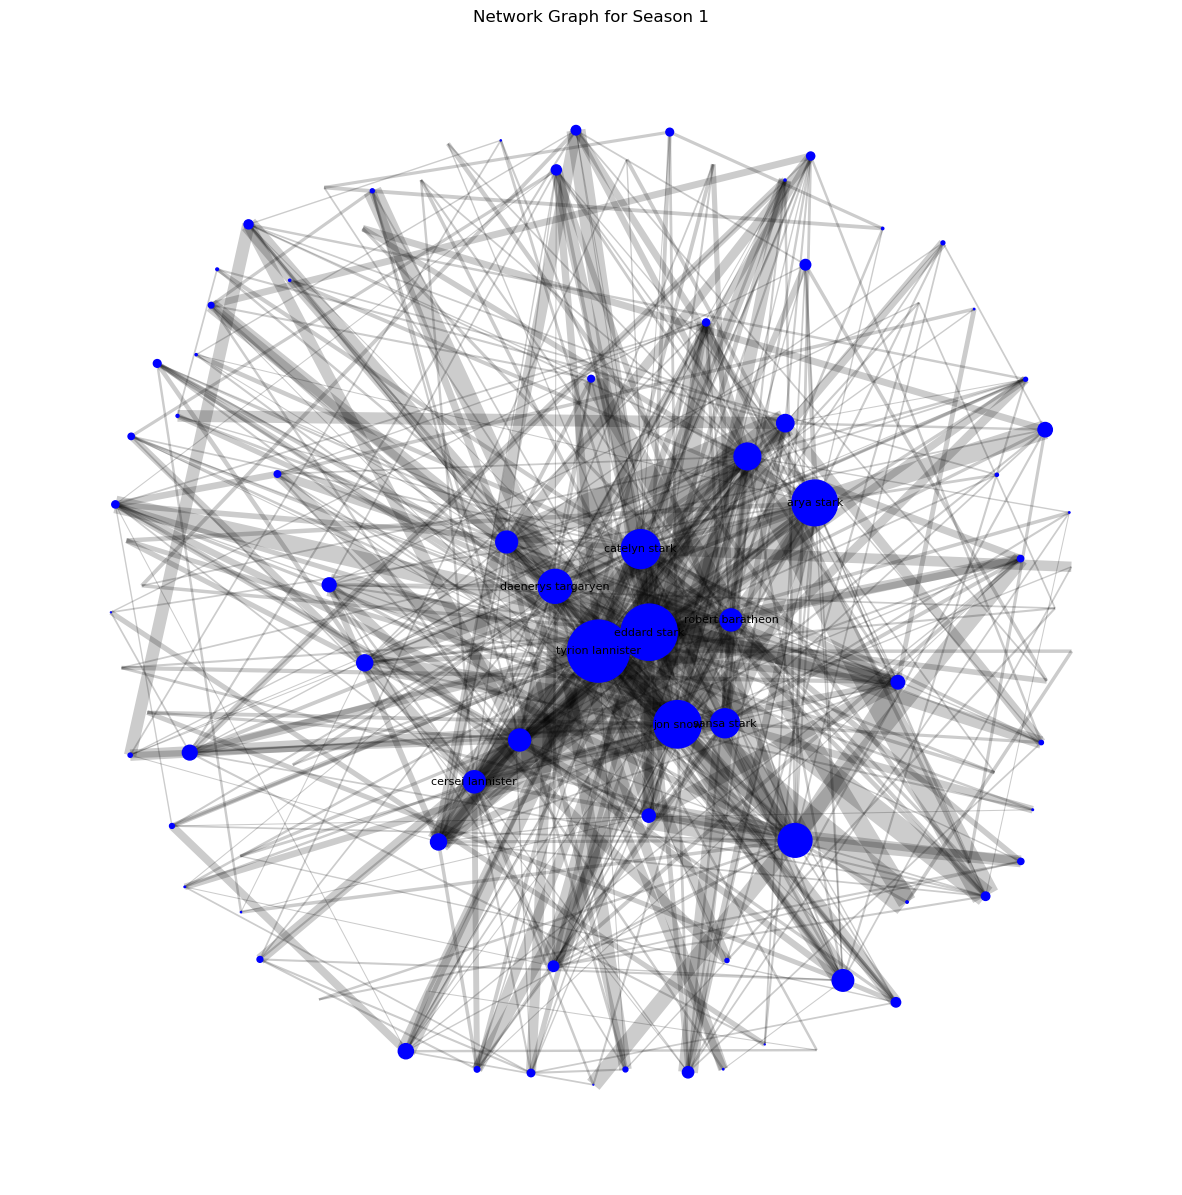

In [22]:
# Assuming `networks` is your dictionary of graphs for each season

# Select a graph for a specific season to visualize
season_name = 'Season 1'  # Example season
G = networks[season_name]

# Calculate betweenness centrality and PageRank for the nodes
betweenness_centrality = nx.betweenness_centrality(G)
pagerank_centrality = nx.pagerank(G)

# Prepare the layout
pos = nx.spring_layout(G, k=5, iterations=50)

# Draw the graph
plt.figure(figsize=(15, 15))

# Draw edges
edges = G.edges(data=True)
edge_weights = [edata['weight']/4 for _, _, edata in edges]
nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_weights)

# Draw nodes
node_sizes = [betweenness_centrality[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')

# Draw node labels
# We will only label the top 10% nodes based on PageRank
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_percent = sorted_pagerank[:len(sorted_pagerank) // 10]
node_labels = {node: node for node, _ in top_10_percent}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title(f"Network Graph for {season_name}")
plt.axis('off')
plt.show()

In [23]:
# Assuming `networks` is your dictionary containing the network for each season
community_networks = {}

for season, network in networks.items():
    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(network)
    
    # Store the partition for later analysis
    community_networks[season] = partition


In [24]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming `networks` and `community_networks` are available

# Function to plot and save the network graph with communities and centrality measures
def plot_and_save_network_graph(network, partition, season_name, output_dir='network_graphs'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Calculate betweenness centrality and PageRank for the nodes
    degree_centrality = nx.degree_centrality(network)
    pagerank_centrality = nx.pagerank(network)

    # Prepare the layout
    pos = nx.spring_layout(network, k=0.1, iterations=50)

    # Draw the graph
    plt.figure(figsize=(15, 15))

    # Draw edges
    edges = network.edges(data=True)
    edge_weights = [edata['weight']/5 for _, _, edata in edges]
    nx.draw_networkx_edges(network, pos, alpha=0.2, width=edge_weights)

    # Draw nodes with community color
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = [partition.get(node) for node in network.nodes()]
    node_sizes = [degree_centrality[node] * 5000 for node in network.nodes()]
    nx.draw_networkx_nodes(network, pos, node_size=node_sizes, cmap=cmap, node_color=node_colors)

    # Draw node labels for the top 20% nodes based on PageRank
    sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)
    top_20_percent = sorted_pagerank[:len(sorted_pagerank) // 3]
    node_labels = {node: node for node, _ in top_20_percent}
    nx.draw_networkx_labels(network, pos, labels=node_labels, font_size=8)

    plt.title(f"Network Graph for {season_name}")
    plt.axis('off')

    # Save the plot as a PNG file
    plot_filename = f"{output_dir}/Network_Graph_{season_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename, bbox_inches='tight')
    plt.close()  # Close the plot to free memory

# Output directory for the network graphs
output_dir = 'final/network_graphs'

# Plotting and saving network graphs for each season
for season, network in networks.items():
    partition = community_networks[season]
    plot_and_save_network_graph(network, partition, season, output_dir=output_dir)


C:\Users\boran\AppData\Local\Temp\ipykernel_3408\1255620286.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


In [25]:
# Assuming community detection has been performed and community_networks is populated

def print_communities_for_season(community_partition, season):
    # Inverting the partition dictionary to group nodes by community
    communities = {}
    for node, comm_id in community_partition.items():
        communities.setdefault(comm_id, []).append(node)
    
    print(f"Season: {season}")
    for comm_id, nodes in communities.items():
        print(f"Community {comm_id}: {', '.join(nodes)}")
    print("\n")

# Applying the function to each season's partition
for season, partition in community_networks.items():
    print_communities_for_season(partition, season)

Season: Season 1
Community 0: eddard stark, robert baratheon, petyr baelish, cersei lannister, arya stark, varys, grand maester pycelle, jaime lannister, sansa stark, joffrey lannister, septa mordane, syrio forel, jory cassel, loras tyrell, renly baratheon, barristan selmy, lord varys, mordane, marillion, meryn trant, king joffrey, gendry baratheon, tobho mott, lancel lannister, mycah, sandor clegane, illyrio mopatis, kings landing baker, stable boy, hugh of vale, janos slynt, mhaegen, kings guard, street urchin
Community 1: jorah mormont, daenerys targaryen, viserys targaryen, mirri maz duur, rakharo, qotho, doreah, illyrio, wine merchant, drogo, irri
Community 2: jon snow, sam, jeor mormont, grenn, pyp, maester aemon, alliser thorne, othell yarwyck, will, gared, waymar royce, pypar, nights watcher
Community 3: shae, tyrion lannister, bronn, tywin lannister, lysa arryn, benjen stark, kevan lannister, yoren, mord, robin arryn, lommy greenhands, hot pie, knight, masha heddle, lannister 

In [27]:
import pandas as pd
import networkx as nx

# Load the IMDb scores CSV
imdb_scores_csv = '../got_imdb.csv'  # Update with your CSV file path
imdb_scores_df = pd.read_csv(imdb_scores_csv)

# Ensure 'Episode' is a string, then extract and process the season numbers
season_imdb_scores = imdb_scores_df.groupby('Season')['Rating'].mean().to_dict()

def find_most_significant_community(network, partition):
    # Calculate centrality measures for the nodes
    degree_centrality = nx.degree_centrality(network)
    pagerank_centrality = nx.pagerank(network)

    # Sum centrality measures within each community
    community_centrality = {}
    for node, community in partition.items():
        if community not in community_centrality:
            community_centrality[community] = {
                'degree_centrality_sum': 0,
                'pagerank_sum': 0,
                'nodes': []
            }
        community_centrality[community]['degree_centrality_sum'] += degree_centrality[node]
        community_centrality[community]['pagerank_sum'] += pagerank_centrality[node]
        community_centrality[community]['nodes'].append(node)

    # Identify the most significant community based on the sum of pagerank centrality
    most_significant_community = max(community_centrality.items(), key=lambda x: x[1]['pagerank_sum'])

    return most_significant_community

# Assuming `networks` and `community_networks` are defined
most_significant_communities = {}
for season, network in networks.items():
    partition = community_networks[season]
    most_significant_communities[season] = find_most_significant_community(network, partition)

# Print the most significant community for each season
for season, (community_id, data) in most_significant_communities.items():
    print(f"Season {season} - Most Significant Community {community_id}:")
    print(f"  Nodes: {data['nodes']}")
    print(f"  Degree Centrality Sum: {data['degree_centrality_sum']}")
    print(f"  PageRank Centrality Sum: {data['pagerank_sum']}\n")


Season Season 1 - Most Significant Community 0:
  Nodes: ['eddard stark', 'robert baratheon', 'petyr baelish', 'cersei lannister', 'arya stark', 'varys', 'grand maester pycelle', 'jaime lannister', 'sansa stark', 'joffrey lannister', 'septa mordane', 'syrio forel', 'jory cassel', 'loras tyrell', 'renly baratheon', 'barristan selmy', 'lord varys', 'mordane', 'marillion', 'meryn trant', 'king joffrey', 'gendry baratheon', 'tobho mott', 'lancel lannister', 'mycah', 'sandor clegane', 'illyrio mopatis', 'kings landing baker', 'stable boy', 'hugh of vale', 'janos slynt', 'mhaegen', 'kings guard', 'street urchin']
  Degree Centrality Sum: 4.413043478260869
  PageRank Centrality Sum: 0.4096895784988481

Season Season 2 - Most Significant Community 0:
  Nodes: ['cersei lannister', 'tyrion lannister', 'varys', 'bronn', 'joffrey lannister', 'shae', 'sansa stark', 'lancel lannister', 'grand maester pycelle', 'janos', 'sandor clegane', 'ros', 'tommen lannister', 'daisy', 'haylene', 'podrick', 'ser 

In [28]:
import pandas as pd
import networkx as nx

# Assuming `networks`, `community_networks`, and `season_imdb_scores` are available

# Function to find the top 5 characters in the most significant community
def top_characters_in_community(network, partition):
    degree_centrality = nx.degree_centrality(network)
    # Find the most significant community ID
    community_id = max(set(partition.values()), key=lambda x: sum(partition[node] == x for node in network))
    # Filter nodes in this community
    community_nodes = [node for node in network if partition[node] == community_id]
    # Sort these nodes by their PageRank and get the top 10
    top_nodes = sorted(community_nodes, key=lambda node: degree_centrality[node], reverse=True)[:10]
    return top_nodes

# Analyze each season
season_analysis = []
for season, network in networks.items():
    partition = community_networks[season]
    top_5_characters = top_characters_in_community(network, partition)
    season_num = int(season.split(' ')[1])  # Extract the season number
    imdb_score = season_imdb_scores.get(season_num, None)

    season_analysis.append({
        'Season': season_num,
        'Top 10 Characters': ', '.join(top_5_characters),
        'Average IMDb Rating': imdb_score
    })

# Create a DataFrame
analysis_df = pd.DataFrame(season_analysis)
#print(analysis_df)

# Optional: Save the DataFrame to a CSV file for further analysis
analysis_df.to_csv('season_character_imdb_analysis.csv', index=False)


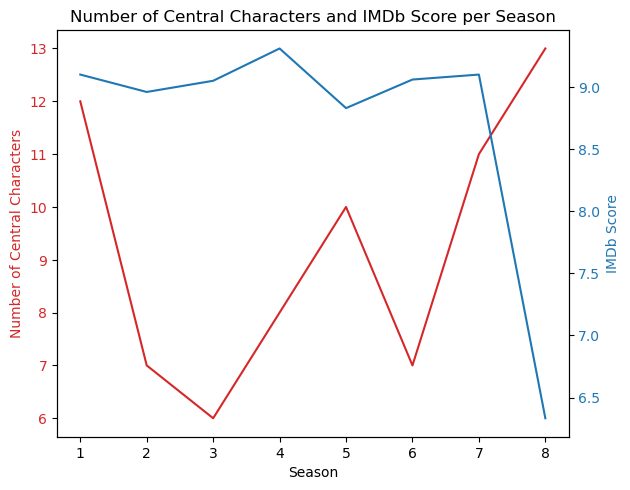

In [36]:
# Load the IMDb scores CSV (update the path as necessary)
imdb_scores_csv = '../got_imdb.csv'
imdb_scores_df = pd.read_csv(imdb_scores_csv)

# Extract season numbers and their corresponding IMDb scores
season_imdb_scores = imdb_scores_df.groupby('Season')['Rating'].mean()

# Threshold for considering a character as 'central'
centrality_threshold = 0.025  # Adjust as needed

# Calculate the number of central characters per season
central_chars_per_season = {}
for season, network in networks.items():
    centrality = nx.pagerank(network)
    central_chars_count = sum(1 for value in centrality.values() if value >= centrality_threshold)
    central_chars_per_season[season] = central_chars_count

# Preparing data for plotting
season_numbers = [int(season.split(' ')[1]) for season in central_chars_per_season.keys()]
central_chars_counts = [central_chars_per_season[season] for season in central_chars_per_season.keys()]
imdb_scores = [season_imdb_scores[season] for season in season_numbers]

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Season')
ax1.set_ylabel('Number of Central Characters', color=color)
ax1.plot(season_numbers, central_chars_counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('IMDb Score', color=color)
ax2.plot(season_numbers, imdb_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Number of Central Characters and IMDb Score per Season')
plt.show()

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Custom tokenizer for TF-IDF
def custom_tokenizer(text):
    tokens = re.findall(r"\b\w[\w']*\b", text.lower())
    return tokens

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english')

for season, partition in community_networks.items():
    season_script = got_df[got_df['Season'].str.contains(f"Season {season.split(' ')[1]}", case=False)]

    # Collect dialogues for each community
    community_dialogues = {}
    for comm in set(partition.values()):
        dialogues = ' '.join(season_script[season_script['Name'].isin([node for node, comm_id in partition.items() if comm_id == comm])]['Sentence'].dropna())
        community_dialogues[comm] = dialogues

    # Compute TF-IDF for all communities together
    all_dialogues = list(community_dialogues.values())
    tfidf_matrix = vectorizer.fit_transform(all_dialogues)
    feature_names = vectorizer.get_feature_names_out()

    # Create word clouds for each community focusing on distinctive words
    for community_id, dialogues in community_dialogues.items():
        community_index = list(community_dialogues.keys()).index(community_id)
        community_scores = dict(zip(feature_names, tfidf_matrix.getrow(community_index).toarray().flatten()))
        
        # Filter words to get those that are distinctive to this community
        distinctive_words = {word: score for word, score in community_scores.items() if score > 0.01 and all(tfidf_matrix.getrow(i).toarray().flatten()[feature_names.tolist().index(word)] < score / 2 for i in range(len(all_dialogues)) if i != community_index)}
        
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(distinctive_words)

        #Saving the wordclouds as png's under the folder wordclouds
        image_path = f"wordclouds/wordcloud_{season}_{community_id}.png"
        wordcloud.to_file(image_path)
        # Plot
        # plt.figure(figsize=(8, 8), facecolor=None)
        # plt.imshow(wordcloud)
        # plt.axis("off")
        # plt.title(f"Word Cloud for Community {community_id} in {season}")
        # plt.show()


In [31]:
# Function to plot the degree distribution for each season and save as PNG
def plot_degree_distribution(network, season_name, output_dir='plots'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    degrees = [degree for _, degree in network.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=range(1, max(degrees) + 1), align='left', rwidth=0.7, color='skyblue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title(f'Degree Distribution in {season_name}')
    plt.xticks(range(1, max(degrees) + 1))

    # Save the plot as a PNG file
    plot_filename = f"{output_dir}/Degree_Distribution_{season_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename, bbox_inches='tight')
    plt.close()  # Close the plot to free memory

# Output directory for the plots
output_dir = 'final/degree_distributions'

# Plotting and saving degree distributions for each season
for season in networks:
    plot_degree_distribution(networks[season], season, output_dir=output_dir)


In [32]:
# Function to print the number of nodes, number of links, and top 5 most connected nodes for each season
def print_network_statistics(network, season_name):
    num_nodes = network.number_of_nodes()
    num_links = network.number_of_edges()
    
    # Calculating the degree for each node and sorting them
    degrees = dict(network.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Top 5 most connected nodes
    top_5_nodes = sorted_degrees[:5]

    print(f"Season: {season_name}")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Links: {num_links}")
    print("Top 5 Most Connected Nodes:")
    for node, degree in top_5_nodes:
        print(f"  {node}: {degree} connections")
    print("\n")

# Printing statistics for each season
for season in networks:
    print_network_statistics(networks[season], season)


Season: Season 1
Number of Nodes: 93
Number of Links: 516
Top 5 Most Connected Nodes:
  eddard stark: 50 connections
  tyrion lannister: 48 connections
  jon snow: 40 connections
  catelyn stark: 38 connections
  daenerys targaryen: 36 connections


Season: Season 2
Number of Nodes: 98
Number of Links: 532
Top 5 Most Connected Nodes:
  tyrion lannister: 46 connections
  daenerys targaryen: 39 connections
  theon greyjoy: 37 connections
  arya stark: 33 connections
  jon snow: 31 connections


Season: Season 3
Number of Nodes: 88
Number of Links: 523
Top 5 Most Connected Nodes:
  tyrion lannister: 34 connections
  robb stark: 33 connections
  bran stark: 31 connections
  arya stark: 30 connections
  talisa: 26 connections


Season: Season 4
Number of Nodes: 109
Number of Links: 486
Top 5 Most Connected Nodes:
  tyrion lannister: 37 connections
  jon snow: 36 connections
  daenerys targaryen: 34 connections
  jaime lannister: 30 connections
  cersei lannister: 28 connections


Season: Se

# ROI

## Statistical Correlation Overview

Statistical correlation is a measure that describes the extent to which two variables change together. In our context, we are interested in how the IMDb scores of 'Game of Thrones' episodes or seasons correlate with other variables (like episode or season number).

### Key Points:

- **Pearson Correlation Coefficient**: This is the most commonly used correlation measure. The Pearson correlation coefficient $ r $ is calculated as follows:

  $$
  r = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum (X_i - \bar{X})^2 \sum (Y_i - \bar{Y})^2}}
  $$

  Where:
  - $ X_i $ and $ Y_i $ are individual sample points.
  - $ \bar{X} $ and $ \bar{Y} $ are means of the samples $ X $ and $ Y $.
  - The summation is over all sample points.

  The coefficient ranges from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.

- **Positive vs Negative Correlation**:
  - *Positive Correlation*: As one variable increases, the other variable also increases.
  - *Negative Correlation*: As one variable increases, the other variable decreases.

- **Statistical Significance**: It’s important to determine whether a calculated correlation is statistically significant, which often requires further statistical testing.

### Usage in Our Analysis:

We will calculate the Pearson correlation coefficient to understand the relationship between IMDb scores and either episode numbers or season numbers. However, it's important to remember that correlation does not imply causation. A high or low correlation does not mean that one variable causes the other to change.


In [8]:
import scipy.stats
import csv

def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            key = f'S{season}E{episode}'
            episodes[key] = {
                'season': season,
                'episode': episode,
                'title': title,
                'rating': rating
            }

    return episodes

# Example usage
file_path = '../got_imdb.csv'
got_episodes = parse_got_csv(file_path)
for key, value in got_episodes.items():
    print(f"{key}: {value}")

def episode_correlation(episodes, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like episode numbers) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

def season_correlation(seasons, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the season level.

    Args:
    seasons (list): List of average IMDb scores for each season.
    values (list): Corresponding values (like season numbers) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(seasons) != len(values):
        raise ValueError("Length of seasons and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(seasons, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Example usage:
# episode_scores = [9.1, 8.8, 8.7, ...]  # List of IMDb scores for each episode
# episode_numbers = [1, 2, 3, ...]        # Corresponding episode numbers
# season_scores = [average_score_season_1, average_score_season_2, ...] # Average IMDb scores per season
# season_numbers = [1, 2, 3, ...]         # Corresponding season numbers

# Calculate correlations and test for significance
# episode_corr, episode_significant = episode_correlation(episode_scores, episode_numbers, 0.05)
# season_corr, season_significant = season_correlation(season_scores, season_numbers, 0.05)

# Get the imdb score for each episode from got_imdb.csv and store in a list 

imdb_scores = []
for key, value in got_episodes.items():
    imdb_scores.append(value['rating'])

print(imdb_scores)

episode_correlation(imdb_scores, imdb_scores, 0.05)



S1E1: {'season': 1, 'episode': 1, 'title': 'Winter Is Coming', 'rating': 9.1}
S1E2: {'season': 1, 'episode': 2, 'title': 'The Kingsroad', 'rating': 8.8}
S1E3: {'season': 1, 'episode': 3, 'title': 'Lord Snow', 'rating': 8.7}
S1E4: {'season': 1, 'episode': 4, 'title': 'Cripples, Bastards, and Broken Things', 'rating': 8.8}
S1E5: {'season': 1, 'episode': 5, 'title': 'The Wolf and the Lion', 'rating': 9.1}
S1E6: {'season': 1, 'episode': 6, 'title': 'A Golden Crown', 'rating': 9.2}
S1E7: {'season': 1, 'episode': 7, 'title': 'You Win or You Die', 'rating': 9.2}
S1E8: {'season': 1, 'episode': 8, 'title': 'The Pointy End', 'rating': 9.0}
S1E9: {'season': 1, 'episode': 9, 'title': 'Baelor', 'rating': 9.6}
S1E10: {'season': 1, 'episode': 10, 'title': 'Fire and Blood', 'rating': 9.5}
S2E1: {'season': 2, 'episode': 1, 'title': 'The North Remembers', 'rating': 8.8}
S2E2: {'season': 2, 'episode': 2, 'title': 'The Night Lands', 'rating': 8.5}
S2E3: {'season': 2, 'episode': 3, 'title': 'What Is Dead M

(0.9999999999999998, True)

### Plotting the scores

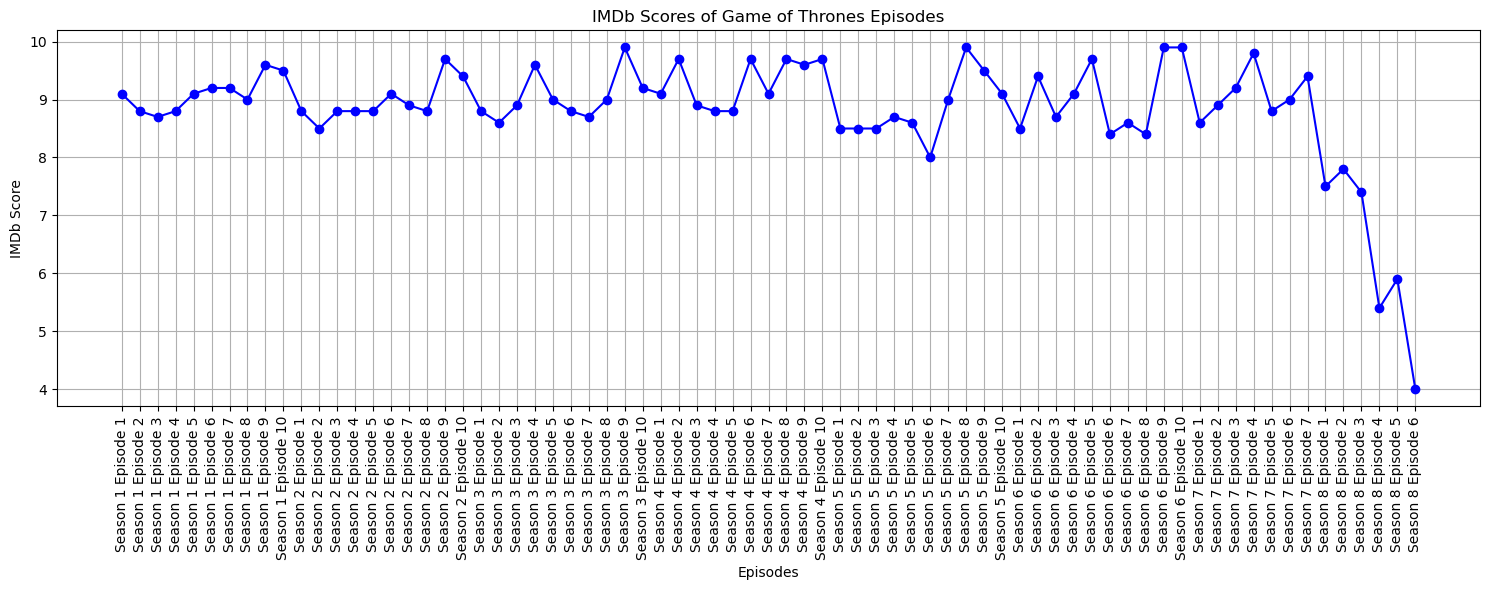

In [14]:
def plot_imdb_scores(episodes):
    # Extract IMDb scores
    scores = [episode['rating'] for episode in episodes.values()]

    # Create formatted episode labels
    episode_labels = [f"Season {episode['season']} Episode {episode['episode']}" for episode in episodes.values()]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(episode_labels, scores, marker='o', linestyle='-', color='b')
    plt.title('IMDb Scores of Game of Thrones Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('IMDb Score')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()

    return plt

# Plot the IMDb scores
got_plot = plot_imdb_scores(got_episodes)
got_plot.show()


In [3]:
import pandas as pd
import networkx as nx
from collections import Counter

# Step 1: Read the Data
got_df = pd.read_csv('../Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions


# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']):
        episode_interactions = process_episode_with_rolling_window(group_df)
        filtered_interactions = filter_interactions(episode_interactions)
        
        G = nx.Graph()
        for pair, count in filtered_interactions.items():
            char1, char2 = tuple(pair)
            G.add_edge(char1, char2, weight=count)
        episode_networks[(season, episode)] = G
    return episode_networks


# Modified Function to Find Top 5 Central Characters in Each Episode
def find_top_central_characters(episode_networks, top_n=5):
    top_central_characters = {}
    for key, G in episode_networks.items():
        if len(G) == 0:
            print(f"No interactions in {key}, skipping.")
            continue
        centrality = nx.degree_centrality(G)
        top_characters = sorted(centrality, key=centrality.get, reverse=True)[:top_n]
        top_central_characters[key] = top_characters
    return top_central_characters

# Step 5: Display Results
episode_networks = create_episode_networks(got_df)
central_characters = find_top_central_characters(episode_networks, 5)
for episode_key in central_characters:
    print(f"Most central character in {episode_key}: {central_characters[episode_key]}")


Most central character in ('Season 1', 'Episode 1'): ['eddard stark', 'catelyn stark', 'jon snow', 'robert baratheon', 'sansa stark']
Most central character in ('Season 1', 'Episode 10'): ['jon snow', 'tyrion lannister', 'daenerys targaryen', 'catelyn stark', 'sam']
Most central character in ('Season 1', 'Episode 2'): ['catelyn stark', 'joffrey lannister', 'tyrion lannister', 'robb stark', 'cersei lannister']
Most central character in ('Season 1', 'Episode 3'): ['eddard stark', 'tyrion lannister', 'catelyn stark', 'petyr baelish', 'jon snow']
Most central character in ('Season 1', 'Episode 4'): ['eddard stark', 'petyr baelish', 'jon snow', 'tyrion lannister', 'sam']
Most central character in ('Season 1', 'Episode 5'): ['eddard stark', 'petyr baelish', 'robert baratheon', 'tyrion lannister', 'renly baratheon']
Most central character in ('Season 1', 'Episode 6'): ['tyrion lannister', 'eddard stark', 'theon greyjoy', 'robert baratheon', 'sansa stark']
Most central character in ('Season 1'

In [5]:
import pandas as pd
import networkx as nx
from collections import Counter
import scipy.stats
import csv

# Load the Game of Thrones scripts data
got_df = pd.read_csv('../Game_of_Thrones_Script.csv', delimiter=';')

# Define non-specific characters to filter out
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Modified Function to Process Each Episode with Rolling Window
def process_episode_with_rolling_window(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)  # 11 lines as a window size
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Function to create episode networks with filtered interactions
def create_episode_networks(got_df):
    episode_networks = {}
    for (season, episode), group_df in got_df.groupby(['Season', 'Episode']):
        episode_interactions = process_episode_with_rolling_window(group_df)
        filtered_interactions = filter_interactions(episode_interactions)
        
        G = nx.Graph()
        for pair, count in filtered_interactions.items():
            char1, char2 = tuple(pair)
            G.add_edge(char1, char2, weight=count)
        episode_networks[(season, episode)] = G
    return episode_networks

# Function to calculate centrality for all characters in each episode
def calculate_all_character_centrality(episode_networks):
    character_centrality = {}
    for key, G in episode_networks.items():
        centrality = nx.degree_centrality(G)
        character_centrality[key] = centrality
    return character_centrality

# Create episode networks
episode_networks = create_episode_networks(got_df)

# Calculate centrality for all characters
all_character_centrality = calculate_all_character_centrality(episode_networks)

# Now, parse the IMDb scores
def parse_got_csv(file_path):
    episodes = {}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            season = int(row['Season'])
            episode = int(row['Episode'])
            title = row['Title']
            rating = float(row['Rating'])

            key = (season, episode)
            episodes[key] = {
                'season': season,
                'episode': episode,
                'title': title,
                'rating': rating
            }

    return episodes

# Parse IMDb data
got_imdb_data = parse_got_csv('../got_imdb.csv')

# Extract IMDb scores for each episode
imdb_scores = {key: value['rating'] for key, value in got_imdb_data.items()}

all_character_centrality, imdb_scores



({('Season 1', 'Episode 1'): {'will': 0.25,
   'waymar royce': 0.16666666666666666,
   'gared': 0.16666666666666666,
   'jon snow': 0.5833333333333333,
   'septa mordane': 0.16666666666666666,
   'eddard stark': 0.8333333333333333,
   'rodrik cassel': 0.16666666666666666,
   'catelyn stark': 0.7083333333333333,
   'robb stark': 0.375,
   'bran stark': 0.3333333333333333,
   'theon greyjoy': 0.20833333333333331,
   'jaime lannister': 0.3333333333333333,
   'cersei lannister': 0.41666666666666663,
   'robert baratheon': 0.5,
   'arya stark': 0.20833333333333331,
   'sansa stark': 0.4583333333333333,
   'tyrion lannister': 0.375,
   'ros': 0.16666666666666666,
   'viserys targaryen': 0.375,
   'daenerys targaryen': 0.375,
   'illyrio': 0.25,
   'benjen stark': 0.29166666666666663,
   'luwin': 0.16666666666666666,
   'jorah mormont': 0.125,
   'sandor clegane': 0.16666666666666666},
  ('Season 1', 'Episode 10'): {'bran stark': 0.11428571428571428,
   'yoren': 0.17142857142857143,
   'osha'

In [6]:
# Function to calculate the Pearson correlation coefficient between IMDb scores and character centrality
def episode_correlation(episodes, values, significance=0.10):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.

    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).

    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Extract the IMDb scores in the order of episodes as they appear in the centrality data
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

# Dictionary to hold correlation results for each character
character_correlations = {}

# Iterate through each character and calculate the correlation with IMDb scores
for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()]):
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least one episode
    if any(centrality_scores):
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        character_correlations[character] = (correlation, is_significant)

character_correlations


{'kraznys': (0.05848497994831512, False),
 'leaf': (-0.05390552827125831, False),
 'orell': (0.034410492254635584, False),
 'doran': (0.0022117364058510955, False),
 'jojen': (0.09561584174532463, False),
 'mhaegen': (0.04571734676170009, False),
 'roose': (0.00037931119312623935, False),
 'lem': (-0.0539055282712583, False),
 'maester': (0.039361859694537066, False),
 'daisy': (-0.005750227365342478, False),
 'sallador': (0.03326448738258029, False),
 'saan': (-0.00409409075477903, False),
 'jaime lannister': (-0.012757665901264252, False),
 'alliser thorne': (0.002484995188772906, False),
 'nights watcher': (0.08307592489905964, False),
 'sam': (-0.20803025843554773, True),
 'mountain': (0.01346958048970419, False),
 'rickard': (-0.05390552827125831, False),
 'randyll': (0.0924574678380805, False),
 'rakharo': (0.0571836939377352, False),
 'leo lefford': (-0.0040940907547790326, False),
 'sissy': (-0.004094090754779026, False),
 'lancel lannister': (0.12259324642182078, False),
 'pro

In [ ]:
# Adjusting the threshold to 1/10 of the total episodes (6-7 episodes)
min_episodes = 67 // 10

# Filter characters based on their appearance in centrality scores (non-null score in at least 1/10 of the episodes)
filtered_characters = {character for character in set().union(*[set(centrality.keys()) for centrality in all_character_centrality.values()])
                       if sum(character in centrality and centrality[character] > 0 for centrality in all_character_centrality.values()) >= min_episodes}

# Displaying the filtered characters
filtered_characters

# Reusing the episode_correlation function to calculate the Pearson correlation
def episode_correlation(episodes, values, significance=0.05):
    """
    Calculate the Pearson correlation coefficient between IMDb scores and given values at the episode level.
    Args:
    episodes (list): List of IMDb scores for each episode.
    values (list): Corresponding values (like centrality scores) to check correlation with IMDb scores.
    significance (float): The significance level to determine statistical significance (default is 0.05).
    Returns:
    tuple: (Pearson correlation coefficient, boolean indicating significance)
    """
    if len(episodes) != len(values):
        raise ValueError("Length of episodes and values must be the same.")

    correlation, p_value = scipy.stats.pearsonr(episodes, values)
    is_significant = p_value < significance
    return correlation, is_significant

# Calculate correlations for the filtered set of characters
filtered_character_correlations = {}
ordered_imdb_scores = [imdb_scores[key] for key in sorted(imdb_scores)]

for character in filtered_characters:
    centrality_scores = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]
    
    # Calculate correlation if the character appears in at least the minimum number of episodes
    if sum(score > 0 for score in centrality_scores) >= min_episodes:
        correlation, is_significant = episode_correlation(ordered_imdb_scores, centrality_scores)
        filtered_character_correlations[character] = (correlation, is_significant)

filtered_character_correlations




In [ ]:
import matplotlib.pyplot as plt

# Identifying the characters with significant correlations
significant_characters = [char for char, (corr, sig) in filtered_character_correlations.items() if sig]

# Creating plots for each significant character
for character in significant_characters:
    character_centrality = [all_character_centrality.get(key, {}).get(character, 0) for key in sorted(all_character_centrality)]

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Episodes (Ordered by Season and Episode Number)')
    ax1.set_ylabel('IMDb Ratings', color=color)
    ax1.plot(ordered_imdb_scores, color=color, marker='o', label='IMDb Ratings')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel(f'{character} Centrality', color=color)
    ax2.plot(character_centrality, color=color, marker='x', label=f'{character} Centrality')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(f'IMDb Ratings and {character} Centrality in Game of Thrones Episodes')
    plt.show()


# Asger

### Initial Processing of "Game of Thrones" Script Data


In [2]:
# Read the CSV file
got_data = pd.read_csv("../Game_of_Thrones_Script.csv", delimiter=';')

# Combine the sentences for each episode
grouped_data = got_data.groupby(['Season', 'Episode'])['Sentence'].apply(' '.join).reset_index()

# Tokenize the text for each episode
grouped_data['Tokenized Sentences'] = grouped_data['Sentence'].apply(word_tokenize)

### Refining Text Data for Analysis

In [3]:
# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Remove stopwords
grouped_data['Cleaned Tokens'] = grouped_data['Tokenized Sentences'].apply(remove_stopwords)

### Analyzing Episode Sentiments


In [4]:
def parse_txt(filepath="../pone.0026752.s001.txt"):
    word_data = {}
    with open(filepath, 'r') as file:
        next(file)  # skip the header
        for line in file:
            parts = line.split('\t')
            if len(parts) < 3:  # Ensure there are enough parts in the line
                continue
            word = parts[0]
            try:
                happiness_avg = float(parts[2])
                word_data[word] = happiness_avg
            except ValueError:  # Handle cases where the value isn't a float
                continue
    return word_data

word_data = parse_txt()

# Functions for sentiment analysis
def sentiment_score_per_file(tokens_dict, word_data):
    scores = {}
    for file_name, tokens in tokens_dict.items():
        scores[file_name] = sentiment_score(tokens, word_data)
    return scores

def sentiment_score(tokens, word_data):
    nominator = 0
    denominator = 0
    for token in tokens:
        if token not in word_data:
            continue
        else:
            frequency = tokens.count(token)
            nominator += (word_data[token]*frequency)
            denominator += frequency
    return nominator/denominator if denominator != 0 else 0

# Prepare data for sentiment analysis
tokens_dict = grouped_data.set_index(['Season', 'Episode'])['Cleaned Tokens'].to_dict()

# Calculate sentiment scores
episode_scores = sentiment_score_per_file(tokens_dict, word_data)


### Organizing Sentiment Scores into a DataFrame

In [5]:
# Convert the dictionary to a DataFrame
episode_list = [f"{season} {episode}" for season, episode in episode_scores.keys()]
score_list = list(episode_scores.values())
score_df = pd.DataFrame({'Episode': episode_list, 'Score': score_list})

# Extract numerical parts for sorting
score_df['Season_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[1]))
score_df['Episode_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[3]))

# Sort by season and episode number
score_df.sort_values(by=['Season_Number', 'Episode_Number'], inplace=True)

### Advanced Sentiment Analysis and Visualization

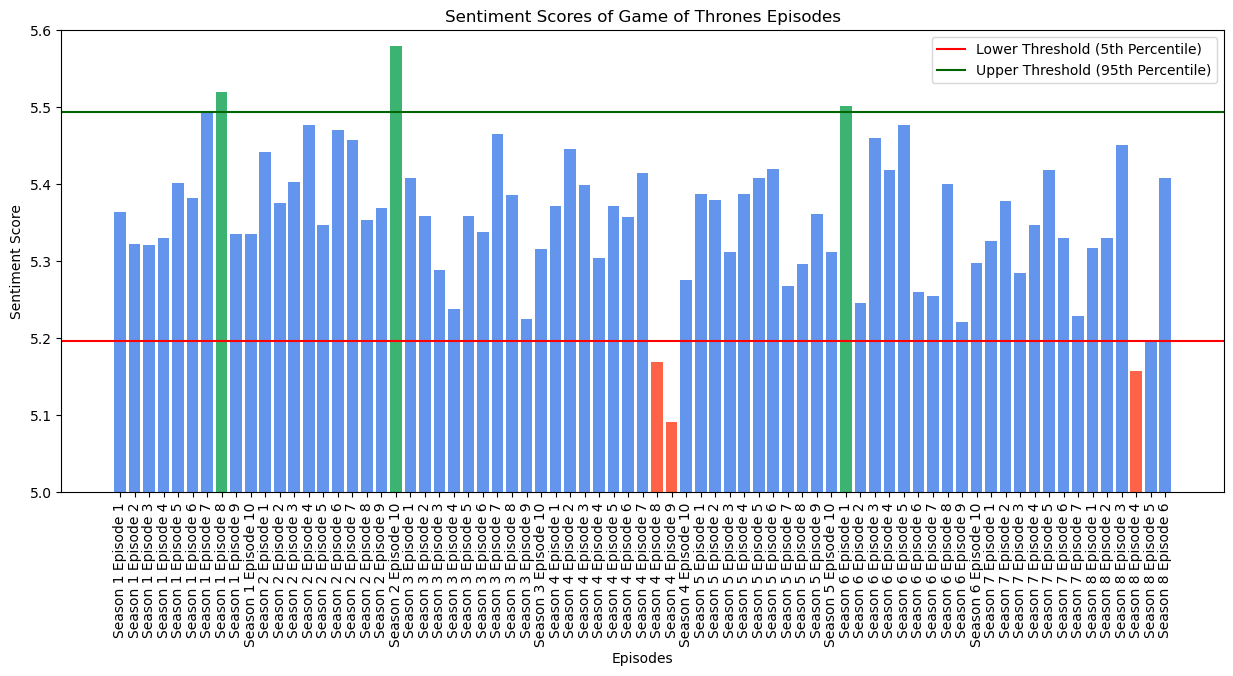

In [30]:
def sentiment_analysis(episode_scores, specific_episode_score, shuffled_means, num_iterations):

    count_lower = sum(1 for mean in shuffled_means if mean < specific_episode_score)
    count_higher = sum(1 for mean in shuffled_means if mean > specific_episode_score)

    proportion_lower = count_lower / num_iterations
    proportion_higher = count_higher / num_iterations

    if proportion_lower < 0.05:
        result = "Lower"
    elif proportion_higher < 0.05:
        result = "Higher"
    else:
        result = "Insignificant"

    return {
        'specific_episode_score': specific_episode_score,
        'proportion_lower': proportion_lower,
        'proportion_higher': proportion_higher,
        'result': result
    }

all_scores = list(episode_scores.values())
num_episodes = 1  # Since we are analyzing one episode at a time
num_iterations = 10000
shuffled_means = []
for _ in range(num_iterations):
    random_sample = np.random.choice(all_scores, size=num_episodes, replace=False)
    shuffled_means.append(np.mean(random_sample))

# Apply the function to each episode
analysis_results = {}
for episode, score in episode_scores.items():
    analysis_results[episode] = sentiment_analysis(episode_scores, score, shuffled_means, num_iterations)


# Convert the results to a DataFrame
analysis_results_df = pd.DataFrame(analysis_results).transpose()

# Calculate thresholds
lower_threshold = np.percentile(shuffled_means, 5)
upper_threshold = np.percentile(shuffled_means, 95)

# Determine the color for each bar based on whether it falls within the thresholds
colors = ['tomato' if (score < lower_threshold) else 'mediumseagreen' if (score > upper_threshold) else 'cornflowerblue' for score in score_df['Score']]

# Make a histogram with episodes on the x-axis and sentiment scores on the y-axis
plt.figure(figsize=(15, 6))
plt.bar(score_df['Episode'], score_df['Score'], color=colors)
plt.xlabel('Episodes')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Game of Thrones Episodes')

# Adding horizontal lines for the thresholds
plt.axhline(y=lower_threshold, color='r', linestyle='-', label='Lower Threshold (5th Percentile)')
plt.axhline(y=upper_threshold, color='darkgreen', linestyle='-', label='Upper Threshold (95th Percentile)')

plt.xticks(rotation=90)  # Rotates the x-axis labels for readability
plt.ylim(5, 5.6)  # Set the y-axis limits
plt.legend()  # Add a legend to display labels
plt.show()

### Highest and lowest sentiment scores

In [34]:
#Print the highest and lowest sentiment score:
print(score_df.loc[score_df['Score'].idxmax()])
print(score_df.loc[score_df['Score'].idxmin()])

Episode           Season 2 Episode 10
Score                        5.579944
Season_Number                       2
Episode_Number                     10
Name: 11, dtype: object
Episode           Season 4 Episode 9
Score                       5.091476
Season_Number                      4
Episode_Number                     9
Name: 39, dtype: object


### Statistically significant episodes

In [35]:
#Print the significant episodes:
print(analysis_results_df[analysis_results_df['result'] != 'Insignificant'])


                    specific_episode_score proportion_lower proportion_higher  \
Season 1 Episode 7                5.493475           0.9411            0.0436   
         Episode 8                5.519391           0.9691            0.0157   
Season 2 Episode 10               5.579944           0.9843               0.0   
Season 4 Episode 8                5.169039           0.0278             0.958   
         Episode 9                5.091476              0.0             0.986   
Season 6 Episode 1                5.501384           0.9564            0.0309   
Season 8 Episode 4                5.157273            0.014            0.9722   
         Episode 5                5.196548            0.042            0.9451   

                     result  
Season 1 Episode 7   Higher  
         Episode 8   Higher  
Season 2 Episode 10  Higher  
Season 4 Episode 8    Lower  
         Episode 9    Lower  
Season 6 Episode 1   Higher  
Season 8 Episode 4    Lower  
         Episode 5    Lower  


### Analysis of colleration with IMBD scores

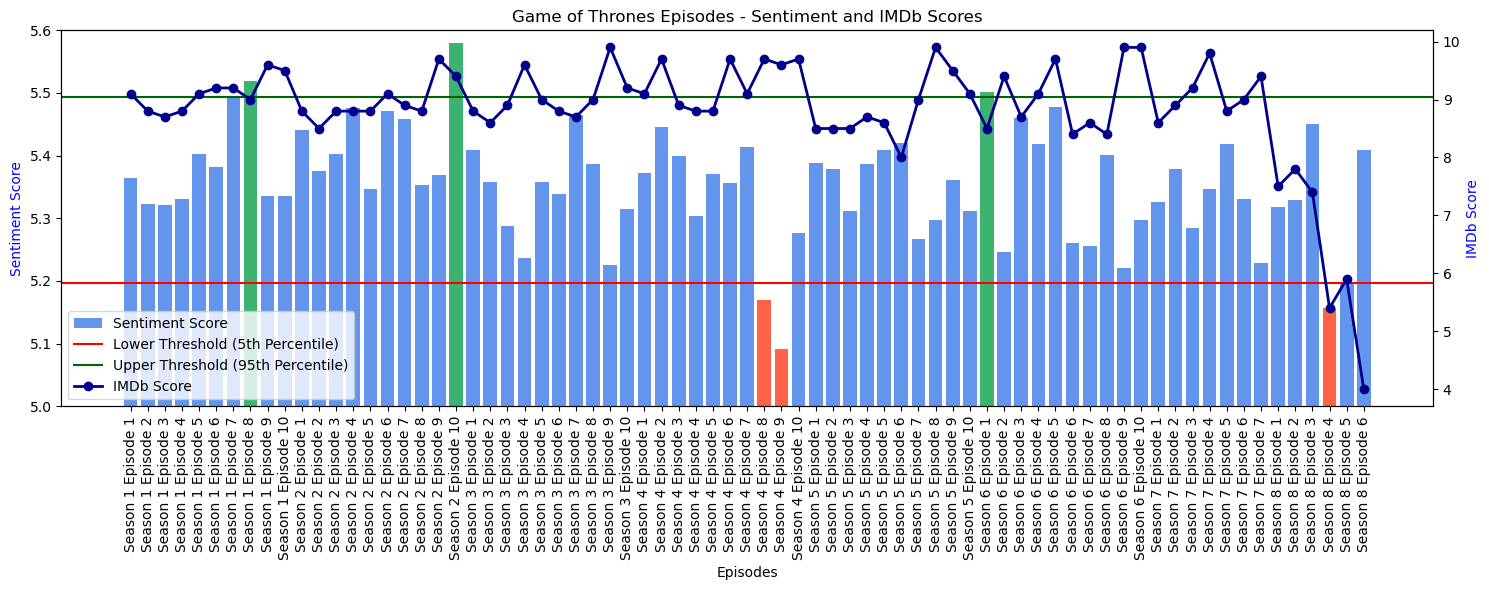

In [42]:
# Create formatted episode labels
episode_labels = [f"Season {episode['season']} Episode {episode['episode']}" for episode in got_episodes.values()]

# Extract IMDb scores
imdb_scores = [episode['rating'] for episode in got_episodes.values()]

# Create a new figure
plt.figure(figsize=(15, 6))

# Plot the sentiment scores
bars = plt.bar(episode_labels, score_df['Score'], color=colors, label='Sentiment Score')

# Add labels and title for sentiment scores
plt.xlabel('Episodes')
plt.ylabel('Sentiment Score', color='b')
plt.title('Game of Thrones Episodes - Sentiment and IMDb Scores')
plt.xticks(rotation=90)
plt.ylim(5, 5.6)

# Adding horizontal lines for the sentiment score thresholds
lower_line = plt.axhline(y=lower_threshold, color='r', linestyle='-', label='Lower Threshold (5th Percentile)')
upper_line = plt.axhline(y=upper_threshold, color='darkgreen', linestyle='-', label='Upper Threshold (95th Percentile)')

# Create a second y-axis for IMDb scores
ax2 = plt.gca().twinx()

# Plot IMDb scores
imdb_line, = ax2.plot(episode_labels, imdb_scores, marker='o', linestyle='-', color='darkblue', linewidth=2, label='IMDb Score')

# Add labels for IMDb scores
ax2.set_ylabel('IMDb Score', color='b')
ax2.grid(False)

# Combine legends from both axes
lns = [bars, lower_line, upper_line, imdb_line]
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='lower left')

plt.tight_layout()
plt.show()